# Autoencoder Development

#### 1. Dependencies

This section could include:
* Library imports.
* Constant definitions

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import gc

In [2]:
gpu_available = torch.cuda.is_available()

if gpu_available:
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

INPUT_SIZE = 3
LATENT_SIZE = 256
KERNEL_SIZE = 3
STRIDE = 1
PADDING = 1 

#### 2. Data Loading & Feature Engineering

This section could include:

* Loading of data files
* Data manipulation
* Feature engineering strategies

In [3]:
images = np.load("subset_1.npy")

num_images = images.shape[0]
training_samples = int((0.75 * num_images) // 1)
batch_size = math.ceil(training_samples / 10)

images = images.reshape(-1, 3, 150, 225)

train_data = images[:training_samples] / 255.
test_data = images[training_samples:] / 255.

train_data = torch.tensor(train_data, dtype = torch.float32)
test_data = torch.tensor(test_data, dtype = torch.float32)

train_dataset = TensorDataset(train_data)
test_dataset = TensorDataset(test_data)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False)

In [4]:
train_data[0].shape

torch.Size([3, 150, 225])

#### 3. Model Development

This section could include:

* Model Definitions
* Hyperparameter Tuning
* Training code
* Optimisation

In [5]:
# Handles creation of encoder and decoder
class Autoencoder(nn.Module):
    def __init__(self, encoder, layers):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.layers = layers
        self.num_layers = len(layers)

        self.loss_f = nn.MSELoss()

        self.layer_data = self.detect_function()
        if encoder:
            self.encode = self.create_model()
            self.encode.to(DEVICE)
        else:
            self.decode = self.create_model()
            self.decode.to(DEVICE)


    def detect_function(self):
        layer_data = []
        previous_node_count = INPUT_SIZE if self.encoder else LATENT_SIZE

        for layer in self.layers:
            a_func, nodes = layer[0], layer[1]
            a_func = a_func.lower()
            if self.encoder:
                layer_data.append(nn.Conv2d(in_channels = previous_node_count, out_channels = nodes, kernel_size = KERNEL_SIZE, stride = STRIDE, padding = PADDING))
            else:
                layer_data.append(nn.ConvTranspose2d(in_channels = previous_node_count, out_channels = nodes, kernel_size = KERNEL_SIZE, stride = STRIDE, padding = PADDING))
            # layer_data.append(nn.Linear(previous_node_count, nodes))
            previous_node_count = nodes

            match a_func:
                case "relu":
                    layer_data.append(nn.ReLU())
                case "lrelu":
                    layer_data.append(nn.LeakyReLU(0.01))
                case "sigmoid":
                    layer_data.append(nn.Sigmoid())
                case "tanh":
                    layer_data.append(nn.Tanh())
                case _:
                    layer_data.append(nn.ReLU())

        # latent space does not need to be activated
        # if self.encoder:
        #     layer_data.append(nn.Linear(previous_node_count, LATENT_SIZE))

        return layer_data
        
    def create_model(self):
        model = nn.Sequential(*self.layer_data)
        
        return model

    def enc(self, x):
        return self.encode(x)
    
    def dec(self, x):
        return self.decode(x)

In [6]:
encoder_data = [
    ("lrelu", 64),
    ("lrelu", 128),
    ("lrelu", 256),
    ("lrelu", 512),
    ("relu", 1024),
]

decoder_data = [
    ("lrelu", 512),
    ("lrelu", 256),
    ("lrelu", 128),
    ("lrelu", 64),
    ("sigmoid", 3),
]

encoder = Autoencoder(True, encoder_data)
decoder = Autoencoder(False, decoder_data)

In [7]:
print(encoder)
print(decoder)

Autoencoder(
  (loss_f): MSELoss()
  (encode): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
  )
)
Autoencoder(
  (loss_f): MSELoss()
  (decode): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 

#### 4. Model Evaluation

This section could include:

* Testing of models trained
* Generation of results

In [ ]:
# Handels autoencoder training
class AutoencoderTrainer:
    def __init__(self, encoder, decoder, learning_rate):
        self.encoder = encoder
        self.decoder = decoder
        self.learning_rate = learning_rate
        self.loss_f = nn.MSELoss()
        self.optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = self.learning_rate)

    def autoencode(self, encoder, decoder, data):
        return decoder.dec(encoder.enc(data))

    def calculate_loss(self, output, target):
        print("output:", output)
        print("target:", target)
        loss = self.loss_f(output, target)
        return loss
    
    def update(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, epochs):
        for epoch in range(1, epochs + 1):
            for batch in train_loader:
                batch = batch[0].to(DEVICE)
                output = self.autoencode(self.encoder, self.decoder, batch)                
                
                loss = self.calculate_loss(output, batch)
                self.update(loss)

            print(f"Epoch: {epoch}, Loss: {loss.item()}")

    def test(self):
        outputs = []
        for sample in test_loader:
            sample = sample[0].to(DEVICE)
            output = self.autoencode(self.encoder, self.decoder, sample)
            outputs.append(output)
        return outputs
    
    def autoencode(self, image):
        image = image.reshape(3, 150, 255)
        image /= 255.
        image = torch.tensor(image, dtype = torch.float32)
        image = image.to(DEVICE)
        
        output = self.autoencode(self.encoder, self.decoder, image)
        output = (output.detach().cpu().numpy() * 255).astype(np.uint8)
        output = np.reshape(output.flatten(), (150, 225, 3))
        
        return output

In [9]:
# encoder_layer_data = [
#     ("lrelu", 64),
#     ("lrelu", 128),
#     ("lrelu", 256),
#     ("lrelu", 512),
#     ("relu", 1024),
# ]

# decoder_layer_data = [
#     ("lrelu", 512),
#     ("lrelu", 256),
#     ("lrelu", 128),
#     ("lrelu", 64),
#     ("sigmoid", 3),
# ]
encoder_layer_data = [
    ("lrelu", 64),
    ("lrelu", 128),
    ("lrelu", 256),
]

decoder_layer_data = [
    ("lrelu", 128),
    ("lrelu", 64),
    ("sigmoid", 3),
]

encoder = Autoencoder(True, encoder_layer_data)
decoder = Autoencoder(False, decoder_layer_data)

trainer = AutoencoderTrainer(encoder, decoder, 0.001)
trainer.train(5)

output: tensor([[[[0.4871, 0.4922, 0.4960,  ..., 0.4944, 0.4928, 0.5022],
          [0.4913, 0.4938, 0.4944,  ..., 0.4940, 0.4941, 0.4998],
          [0.4905, 0.4883, 0.4913,  ..., 0.4919, 0.4915, 0.4967],
          ...,
          [0.4912, 0.4859, 0.4879,  ..., 0.4948, 0.4934, 0.4998],
          [0.4922, 0.4913, 0.4935,  ..., 0.4960, 0.4941, 0.5006],
          [0.4919, 0.4878, 0.4866,  ..., 0.4883, 0.4895, 0.4969]],

         [[0.4822, 0.4780, 0.4787,  ..., 0.4804, 0.4806, 0.4786],
          [0.4760, 0.4772, 0.4764,  ..., 0.4794, 0.4807, 0.4795],
          [0.4758, 0.4750, 0.4735,  ..., 0.4763, 0.4768, 0.4780],
          ...,
          [0.4709, 0.4746, 0.4742,  ..., 0.4831, 0.4837, 0.4837],
          [0.4771, 0.4813, 0.4810,  ..., 0.4836, 0.4834, 0.4816],
          [0.4850, 0.4892, 0.4898,  ..., 0.4901, 0.4888, 0.4873]],

         [[0.5420, 0.5399, 0.5390,  ..., 0.5430, 0.5420, 0.5461],
          [0.5390, 0.5382, 0.5325,  ..., 0.5386, 0.5419, 0.5475],
          [0.5377, 0.5370, 0.5304,

In [10]:
print(encoder)
print(decoder)

Autoencoder(
  (loss_f): MSELoss()
  (encode): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
  )
)
Autoencoder(
  (loss_f): MSELoss()
  (decode): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)


#### 5. Figure Creation

This section could include:

* Creation of figures for the report.
* Creationg of tables for the report.

In [11]:
imgs = trainer.test()

for i in range(len(imgs)):
    imgs[i] = (imgs[i].detach().cpu().numpy() * 255).astype(np.uint8)
    imgs[i] = np.reshape(imgs[i].flatten(), (150, 225, 3))
    
    

In [12]:
imgs[0].shape
imgs[0] = np.reshape(imgs[0].flatten(), (150, 225, 3))

In [13]:
imgs[1].shape

(150, 225, 3)

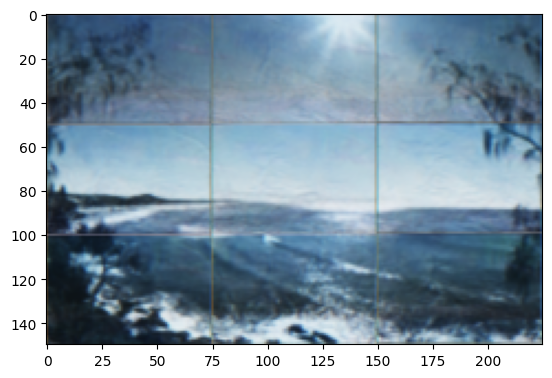

In [22]:
plt.imshow(imgs[12])

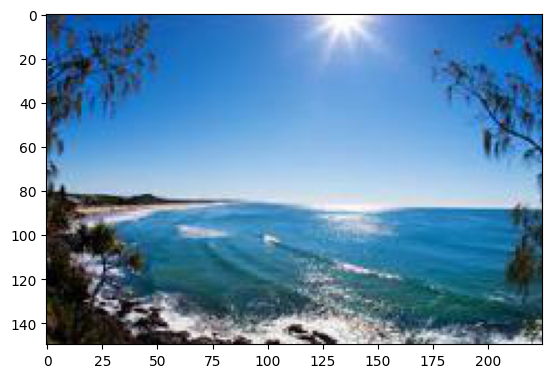

In [23]:
plt.imshow(np.reshape((test_data[12].numpy() * 255).astype(np.uint8), (150, 225, 3)))

In [24]:
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.synchronize()